## Aluminum and Composite Fuel Tank Analysis

Ondrej Fercak, ofercak@pdx.edu

Erin Schmidt, esch2@pdx.edu

Ian Zabel, ibz@pdx.edu

@psas

### Introduction
The purpose of this analysis is to determine the failure criterea of the aluminum or carbon fiber composite fuel tank walls. An Abaqus 6.14 model is developed assuming that the fuel tank is axisymmetric with some simplifications regarding the internals of the fuel tank. An initial model is developed and run, assuming there is no baffling or plumbing within the fuel tank, to ensure the composite definitions are sensible. A more advanced model is then developed using Solidworks as well as Abaqus that includes the internals expected to be present.

**Internals:**
- Fuel line
- Baffling fins
- Baffling net
- Transition region ribbing

**Propellant:**
- **Fuel:** Isopropyl, 70%
- **Oxidizer:** Liquid Oxygen

### Aluminum Theory
For the propellant, the oxidizer to fuel ratio $OF$ is set as $1.3$, leading to the following expressions:

$$\frac{m_{ox}}{m_{f}}=OF=1.3$$

With the mass of the propellant defined by the [LV4 Design Optimization](https://github.com/psas/liquid-engine-analysis/blob/master/optimization/LV4_Optimization.ipynb), the required volume for each of the sections is defined by the following set of expressions, assuming both the fuel and oxidizer tanks have the same hemishperical endcaps:

$$m_{p}=m_{ox}+m_{f}$$
$$V_{ox} = \rho_{ox} m_{ox} = 2 \left(\frac{4}{3} \pi\right)\left(R_{o}-t\right)^3 + \pi L_{ox} \left(R_{o}-t\right)^2$$
$$V_{f} = \rho_{f} m_{f} = 2 \left(\frac{4}{3} \pi\right)\left(R_{o}-t\right)^3 + \pi L_{f} \left(R_{o}-t\right)^2$$

The goal with using these definitions is to drive the cylindrical tank portion lengths $L_{ox}$ and $L_{f}$ using the ratio $OF=1.3$ and known propellant densities $\rho_{ox}$ and $\rho_{f}$. Rearranging to solve for the tank lengths leads to the following expressions:

$$L_{ox}(t)=\frac{\rho_{ox} \left(m_{p}-\frac{m_{p}}{1+OF}\right)}{\pi (R_{o}-t)^2}-2 \frac{4}{3}(R_{o}-t)$$
$$L_{f}(t)=\frac{\rho_{ox} \left(\frac{m_{p}}{1+OF}\right)}{\pi (R_{o}-t)^2}-2 \frac{4}{3}(R_{o}-t)$$

With the lengths of the cylindrical portions defined as functions of the wall thickness, the next step is to determine the wall minimum thickness with a factor of safety. To do this, the properties of the material are considered.

| Material | Failure Criteria |
| -------- | ---------------- |
| Ductile  | Von Mises        |
| Brittle  | Mohr's Theory    |

$$\sqrt{\frac{(\sigma_{1}-\sigma_{2})^2 + (\sigma_{2}-\sigma_{3})^2 + (\sigma_{3}-\sigma_{1})^2}{2}} \le \sigma_{y}$$

### Aluminum Assumptions
To perform this analysis using composite or aluminum, the pressure vessel is assumed to be thin-walled. To apply this assumption the wall thickness $t$ must be much smaller than a characteristic dimension $R$, in this case the tank radius $r$.

$$\frac{R}{t}>10$$

The simplifed pressure vessel is assumed to be axisymmetric, and the advanced model vessel is assumed to by symmetric about both the $x,z$ and $y,z$ planes. To simplify manufacturing and design, both the oxidizer and fuel tanks are the same material, wall thickness, radius, and have the same hemispherical endcaps. One of the tanks will have a fuel line running through the center, while the other tank will only have an opening for that specific fuel line at the bottom.

### Composite Overwrap Pressure Vessel

**General Structure:**
- Liner
- Hoop wrap
- Helical wrap

### Composite Theory

([K]+lambdai[S]){psi}i={0}
K=stiffness
S=stress stiffness
lambdai=ith eigenvalue
psii=ith eigenvector of displacements
'Block Lanczos'

### FEA Procedure





FUEL TANK PARAMETERS
--------------------
Tank Radius         = 0.13 m
Tank Wall Thickness = 2.00 mm
Volume, lox         = 0.035 m^3
Volume, fuel        = 0.545 m^3

FUEL TANK MASS
--------------
Mass, Lox   = 39.57 kg
Mass, Eth.  = 30.43 kg
Mass, Prop. = 70.00 kg


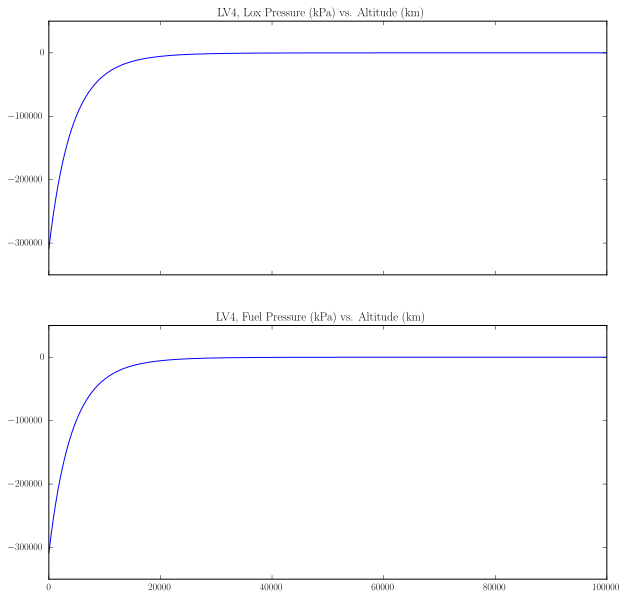

In [1]:
import math as m
import numpy as np
import matplotlib
import matplotlib.pyplot as plot
import pylab
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

# Ondrej Fercak
# Ian Zabel
# Note: - Dimensions from LV4 MDO
#       - Atmo pressure from LV4 MDO
#       - All calculations assume hemisphere endcaps

# Dimensions and Material Properties

Do = 0.254  # Outer tank diameter (m)
Ro = Do/2   # Outer tank radius (m)
L  = 1.2    # Overall tank length (m)
TW = 15     # Thin-walled assumption limit
t  = 0.002  # Wall thickness (m)
FS = 1.1    # Factor of safety
Su = 290e6  # Ultimate tensile strength, Al (Pa)
Sy = 240e6  # Yield strength, Al (Pa)
TL = Ro*0.3 # Transition region length (m)

# Propellant Parameters
# Note: Volume values TEMP

OF   = 1.3   # Oxidizer to fuel ratio
rhof = 852.3 # Density, ethanol fuel (kg/m^3)
rhoo = 1141  # Density, lox (kg/m^3)

# Pressure
# Note: Use either np.all() or np.any() for ineq. def

def atmo(x):
    if np.all(x < 11000):
        T = 15.04-0.0065*x
        P = 101.3*((T+273.1)/288.1)**5.26
    elif np.all(11000 <= x) & np.all(x < 25000):
        T = -56.46
        P = 22.65*exp(1.73-0.00016*x) 
    else:
        T = -131.2+0.003*x
        P = 2.488*((T+273.1)/216.6)**(-11.4)

    rho = P/(0.29*(T+273.1)) # Density, ambient air (kg/m^3)
    Pa  = P*1000             # Pressure, ambient air (Pa)
    Ta  = T+273.1            # Temperature, ambient air (K)
    return Pa, rho, Ta

x  = np.arange(0, 1e5, 1) # Altitude (m)
Pa = atmo(x)[0]           # Atmospheric pressure (Pa)
Po = 50-Pa                # Pressure, lox, abs. (Pa)
Pf = 50-Pa                # Pressure, fuel, abs. (Pa)

# Required Mass
mp = 70           # Mass, propellant (kg)
mf = mp/(1+OF)    # Mass, fuel (kg)
mo = mp-mp/(1+OF) # Mass, lox (kg)

Endo = 2*(4/3)*m.pi*Ro**3 # End cap volume, lox (m^3)
Endf = 2*(4/3)*m.pi*Ro**3 # End cap volume, fuel (m^3)

CLo = rhoo*mo/(m.pi*(Ro-t)**2)-(8/3)*(Ro-t)    # Cyl. length, lox (m)
CLf = rhof*mf/(m.pi*(Ro-t)**2)-(8/3)*(Ro-t)    # Cyl. length, fuel (m)
Vo = mo/rhoo # Volume, lox (m^3)
Vf = mf/rhof # Volume, fuel (m^3)

mo = rhoo*Vo # Mass, lox (kg)
mf = rhof*Vf # mass, fuel (kg)
mp = mo+mf   # Mass, propellant (kg) 

# Stress, Cylindrical Portion

Sho = Po*Ro/t # Hoop stress, cyl, lox (Pa)
Shf = Pf*Ro/t # Hoop stress, cyl, fuel (Pa)
Sao = 0.5*Sho # Axial stress, cyl, lox (Pa)
Saf = 0.5*Shf # Axial stress, cyl, fuel (Pa)

# Stress, Endcaps
# Note: Static equilibrium, stress net resultant

Sno = Sao # Stress, endcaps, lox (Pa)
Snf = Saf # Stress, endcaps, Fuel (Pa)

# Composite Overwrap

# Parameters
# Note: typical El = 130e9 Pa
#               Et = 11e9 Pa
#               v  = 0.27

# Expected Values (TEMP): Vf  = 0.55
#                         E22 = 130 GPa
#                         E11 = 11 GPa
#                         G12 = 5.5 GPa
#                         v12 = 0.27

rhofib = 2500    # Density, fiber (kg/m^3) (TEMP)
rhom   = 1611    # Density, matrix (kg/m^3) (TEMP)
wf     = 0.65    # Weight, fiber (kg) (TEMP)
wm     = 0.35    # Weight, matrix (kg) (TEMP)
Ef     = 106.3e9 # Modulus, fiber (Pa)
Em     = 3.4e9   # Modulus, matrix (Pa)

Vf = (wf/rhofib)/((wf/rhofib)+(wm/rhom)) # Volume fraction, fiber
Vm = 1-Vf                                # Volume fraction, matrix

rhocom = rhofib*Vf+rhom*Vm # Density, composite (kg/m^3)

vf = 0.26 # Poisson's ratio, fiber (TEMP)
vm = 0.33 # Poisson's ratio, matrix (TEMP)

Gf = Ef/(2*(1+vf)) # Shear modulus, fiber (Pa)
Gm = Em/(2*(1+vm)) # Shear modulus, matrix (Pa)

Th = 45 # Weave angle (deg.)

# Major Poisson's: Ratio of trans. contraction strain to long. extension strain in the direction of the stretch force
# Tensile --> positive

E22 = Ef*Em/(Em*Vf+Ef*Vm) # Modulus, longitudinal (Pa)
E11 = Ef*Vf+Em*Vm         # Modulus, transverse (Pa)
v12 = vf*Vf+vm*Vm         # Poisson's ratio, major
v21 = E22*v12/E11         # Poisson's ratio, minor
G12 = Gf*Gm/(Gf*Vm+Gm*Vf) # Shear modulus

# Windenburg and Trilling Equation
# Carbon Composite Epoxy Helix at 45 deg.

Ex  = E22/(m.cos(Th)**4 + (E22/E11)*m.sin(Th)**4 + 0.25*((E22/E11)-2*v12)*m.sin(2*Th)**2) # Modulus, x (Pa)
Ey  = E22/(m.sin(Th)**4 + (E22/E11)*m.cos(Th)**4 + 0.25*((E22/E11)-2*v12)*m.sin(2*Th)**2) # Modulus, y (Pa) 
Pcr = (2.42*Ex*(t/Do)**2.5)/(((1-v12**2)**0.75)*(L/Do - 0.45*m.sqrt(t/Do)))               # Critical pressure (Pa)

# Results

print('\n')
print('FUEL TANK PARAMETERS')
print('--------------------')
print('Tank Radius         = {0:.2f} m'.format(Ro))
print('Tank Wall Thickness = {0:.2f} mm'.format(t*1000))
print('Volume, lox         = {0:.3f} m^3'.format(Vo))
print('Volume, fuel        = {0:.3f} m^3'.format(Vf))
print('\nFUEL TANK MASS')
print('--------------')
print('Mass, Lox   = {0:.2f} kg'.format(mo))
print('Mass, Eth.  = {0:.2f} kg'.format(mf))
print('Mass, Prop. = {0:.2f} kg'.format(mp))

# Plotting
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
f, (ax1, ax2) = plot.subplots(2, sharex=True)
ax1.plot(x, Po)
ax1.yaxis.major.locator.set_params(nbins=6)
ax1.set_title('LV4, Lox Pressure (kPa) vs. Altitude (km)')
ax2.plot(x, Pf)
ax2.yaxis.major.locator.set_params(nbins=6)
ax2.set_title('LV4, Fuel Pressure (kPa) vs. Altitude (km)')
plot.show()